<a href="https://colab.research.google.com/github/diegoislasm/Store-sales-prediction/blob/main/Sales_prediction_based_on_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Store sales prediction with date and weather

## Import libraries

In [1]:
!pip install --upgrade scikit-learn==1.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 16.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.0 which is incompatible.
bigframes 1.37.0 requires scikit-learn>=1.2.2, but you have scikit-learn 1.2.0 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.0 which is incompatible.


In [2]:
import requests
import pandas as pd
pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit

## Data collection

### Download dataset

In [3]:
! gdown --id 10KbcMamNLJlmAtLQ98pls9OngW3k4jG7
! gdown --id 1SRWxGkMqB6adbaoVV9ibLtTErBC2iGgw

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=10KbcMamNLJlmAtLQ98pls9OngW3k4jG7
To: /content/weather_mexico_city.csv
100% 471k/471k [00:00<00:00, 16.2MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SRWxGkMqB6adbaoVV9ibLtTErBC2iGgw
To: /content/store_sales.csv
100% 30.2k/30.2k [00:00<00:00, 44.5MB/s]


### Read files

In [4]:
def read_file (filename):
  '''Read csv file and return a dataframe'''
  df = pd.read_csv(filename)
  return df

In [5]:
# Call 'read_file' function to read csv files and return a dataframe
historical_sales = read_file('/content/store_sales.csv')
historical_weather = read_file('/content/weather_mexico_city.csv')

## Initial EDA

### Check data types

In [6]:
historical_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1483 entries, 0 to 1482
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1483 non-null   object 
 1   sales   1483 non-null   float64
dtypes: float64(1), object(1)
memory usage: 23.3+ KB


In [7]:
historical_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1766 entries, 0 to 1765
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   datetime          1766 non-null   object 
 1   tempmax           1766 non-null   float64
 2   tempmin           1766 non-null   float64
 3   temp              1766 non-null   float64
 4   feelslikemax      1766 non-null   float64
 5   feelslikemin      1766 non-null   float64
 6   feelslike         1766 non-null   float64
 7   dew               1766 non-null   float64
 8   humidity          1766 non-null   float64
 9   precip            1766 non-null   float64
 10  precipprob        1766 non-null   int64  
 11  precipcover       1766 non-null   float64
 12  preciptype        1025 non-null   object 
 13  snow              1766 non-null   int64  
 14  snowdepth         1766 non-null   float64
 15  windgust          1766 non-null   float64
 16  windspeed         1766 non-null   float64


### Check for null values

In [8]:
def check_na(df):
  '''Check for null values in a dataframe and print the count'''
  missing_count = df.isnull().sum()
  print(missing_count)
  print('\n')

In [9]:
# Call 'check_na' function to check null values
print('Missing values in historical_weather dataframe:\n')
check_na(historical_weather)
print('Missing values in historical_sales dataframe:\n')
check_na(historical_sales)

Missing values in historical_weather dataframe:

datetime              0
tempmax               0
tempmin               0
temp                  0
feelslikemax          0
feelslikemin          0
feelslike             0
dew                   0
humidity              0
precip                0
precipprob            0
precipcover           0
preciptype          741
snow                  0
snowdepth             0
windgust              0
windspeed             0
winddir               0
sealevelpressure      0
cloudcover            0
visibility            0
solarradiation        0
solarenergy           0
uvindex               0
severerisk          766
sunrise             400
sunset              400
moonphase           400
conditions          400
description         400
icon                400
stations            400
dtype: int64


Missing values in historical_sales dataframe:

date     0
sales    0
dtype: int64




### Summary statistics

In [10]:
print('Summary statistics of historical_weather dataframe:\n')
print(historical_weather.describe())
print('\n')
print('Summary statistics of historical_sales dataframe:\n')
historical_sales.describe()

Summary statistics of historical_weather dataframe:

           tempmax      tempmin        temp  feelslikemax  feelslikemin  \
count  1766.000000  1766.000000  1766.00000   1766.000000   1766.000000   
mean     25.988109     8.710589    17.46846     25.575142      8.383012   
std       3.342014     4.036355     2.55524      2.864947      4.347057   
min      15.400000    -5.900000    10.60000     15.400000    -10.200000   
25%      23.900000     6.000000    15.80000     23.900000      5.100000   
50%      26.000000     9.200000    17.50000     26.000000      9.100000   
75%      28.000000    12.000000    19.10000     27.375000     12.000000   
max      36.500000    18.700000    25.50000     36.300000     18.700000   

         feelslike          dew     humidity       precip   precipprob  \
count  1766.000000  1766.000000  1766.000000  1766.000000  1766.000000   
mean     17.354134     7.090883    56.262458     2.276409    53.680634   
std       2.545474     4.443207    14.305841     

,sales
count,1483.000000
mean,35287.786322
std,7341.356719
min,16151.000000
25%,30777.395000
50%,35044.000000
75%,38883.570000
max,87496.370000


## Data Cleaning

### Clean weather data

Keep only importat columns, format column rain

In [11]:
def clean_weather_data(df):
  '''Keep only importat columns, rename date column and preciptype, format is_rain'''
  df = df[['datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'precip', 'precipcover', 'preciptype', 'windgust', 'windspeed']]
  df = df.rename(columns={'datetime': 'date', 'preciptype': 'is_rain'})
  df['is_rain'] = df['is_rain'].fillna('no_rain')
  return df

In [12]:
# Call 'clean_weather_data' on 'historical_weather' dataframe
historical_weather = clean_weather_data(historical_weather)

### Format date column and making it index

In [13]:
def date_to_datetime_index(df):
  '''Convert date column datatype to pandas datetime and make it the index'''
  df['date'] = pd.to_datetime(df['date'], dayfirst=True)
  df = df.set_index('date')
  return df

In [14]:
# Call 'date_to_datetime_index' function to formate 'historical_sales' and 'historical_weather' dataframes
historical_sales = date_to_datetime_index(historical_sales)
historical_weather = date_to_datetime_index(historical_weather)

### Merge both dataframes

In [15]:
# Merge dataframes in new dataframe 'data'
data = historical_sales.join(historical_weather, how = 'inner')

Check data on new dataframe

In [16]:
data.head()

,sales,tempmax,tempmin,temp,feelslikemax,feelslikemin,precip,precipcover,is_rain,windgust,windspeed
date,,,,,,,,,,,
2020-10-02,37455.31,19.4,4.7,12.7,19.4,2.7,0.0,0.0,no_rain,34.2,20.5
2020-10-03,37923.31,23.0,5.1,15.1,23.0,2.5,0.0,0.0,no_rain,28.8,16.6
2020-10-04,36265.82,21.1,11.1,15.0,21.1,11.1,0.0,0.0,no_rain,44.3,29.0
2020-10-05,40641.34,24.0,4.1,13.9,24.0,2.2,0.0,0.0,no_rain,31.3,25.8
2020-10-06,39052.39,23.0,5.9,14.6,23.0,5.0,0.0,0.0,no_rain,33.1,22.3


## Data preparation (feature engineering)

### Label Encoding

In [17]:
def add_is_rain(df):
  '''Label encode is_rain column with 1 for rain and 0 for no_rain'''
  df['is_rain'] = df['is_rain'].replace({'rain': 1, 'no_rain': 0})
  return df

### Create date features functions

#### Basic date feature

In [18]:
def add_date_features(df):
  '''Add weekday, week, day, month, year, day_of_year features to dataframe'''
  df['weekday'] = df.index.dayofweek
  df['week'] = df.index.isocalendar().week
  df['day'] = df.index.day
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['day_of_year'] = df.index.dayofyear
  return df

#### Holiday feature

In [19]:
# Create list of holidays
holidays = [
    (1, 6), #Three wisemen Day
    (2, 14), #Valentine's Day
    (9, 15), #Independence Day
    (12, 12), #Virgen de Guadalupe Day
    (12, 24), #Christmas Day
    (12, 31) #New Years Day
]

def add_holidays(df):
  '''
  Add 'is_holiday' feature to dataframe with 'holidays' list of holidays
  '''
  # Serch on index for holidays dates and put 1 for yes and 0 for no
  df['is_holiday'] = df.index.map(
    lambda x: 1 if (x.month, x.day) in holidays else 0)
  return df

#### Sunday feature

In [20]:
def add_sunday(df):
  '''
  Add is_sunday feature to dataframe with 'weekday' column number
  '''
  df['is_sunday'] = (df['weekday'] == 6).astype(int)
  return df

#### Payday feature

In [21]:
def add_payday(df):
  '''
  Add is_payday feature to dataframe getting the 15th and last of the month which are paydays,
  adjusting to the previous Friday if payday is on a weekend and check if index matches a payday
  '''
  # Get the 15th and last day of the month
  fifteenth = df.index.to_period('M').to_timestamp('ms') + pd.offsets.Day(14)
  last_day = df.index.to_period('M').to_timestamp('M')

  # Adjust to the previous Friday if payday is on a weekend
  fifteenth = fifteenth.where(fifteenth.weekday <= 4, fifteenth - pd.offsets.Week(weekday=4))
  last_day = last_day.where(last_day.weekday <= 4, last_day - pd.offsets.Week(weekday=4))

  # Check if the index matches a payday
  df['is_payday'] = ((df.index.isin(fifteenth)) | (df.index.isin(last_day))).astype(int)

  return df

### Create lag features functions

#### Holidays lag feature

In [22]:
# Create list of day lags for holidays
holiday_lags = [1, 2, 3]

def add_holiday_lag(df):
  '''
  Add 'is_holiday_x_lag' features to dataframe with 'holiday_lags' list of lags
  '''
  for lag in holiday_lags:
    df[f'is_holiday_{lag}_lag'] = df['is_holiday'].shift(lag)
  return df

#### Sales lag feature

In [23]:
# Create list of day lags for sales
lags = [1, 7, 14, 28, 364]

def add_lags(df):
  '''
  Add 'sales_lag_x' features to dataframe with 'lags' list of lags
  '''
  for lag in lags:
    df[f'sales_lag_{lag}'] = df['sales'].shift(lag)
  return(df)

### Create rolling averages function

In [24]:
# Create list of rolling windows
rolling_windows = [7, 14, 28, 364]

def add_roll_avg(df):
  '''
  Add 'sales_rolling_avg_x' features to dataframe with 'rolling_windows' list of rolling windows
  '''
  for rolling_window in rolling_windows:
    df[f'sales_rolling_avg_{rolling_window}'] = df['sales'].rolling(window=rolling_window, min_periods=1).mean()
  return(df)

### Add all features

In [25]:
def add_features(df):
  '''
  Call all functions to add features to dataframe
  '''
  df = df.copy()
  df = add_date_features(df)
  df = add_is_rain(df)
  df = add_holidays(df)
  df = add_sunday(df)
  df = add_payday(df)
  df = add_holiday_lag(df)
  df = add_lags(df)
  df = add_roll_avg(df)
  return df

In [26]:
# Add all features to 'data' dataframe
data = add_features(data)

<ipython-input-17-a6233e6d2d21>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_rain'] = df['is_rain'].replace({'rain': 1, 'no_rain': 0})


## Advanced EDA

### Sales trends over time

#### All sales over time

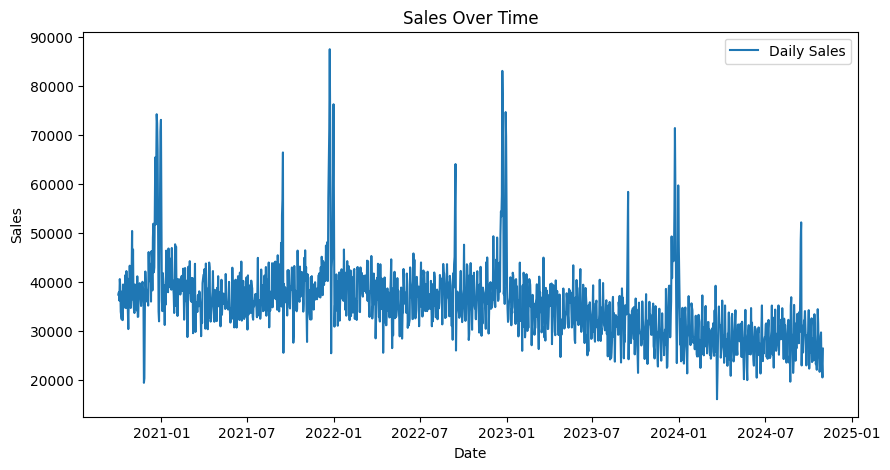

In [27]:
# Plot daily sales
plt.figure(figsize=(10, 5))
plt.plot(data.index, data['sales'], label='Daily Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.legend()
plt.show()

#### Weekly & Monthly Trends

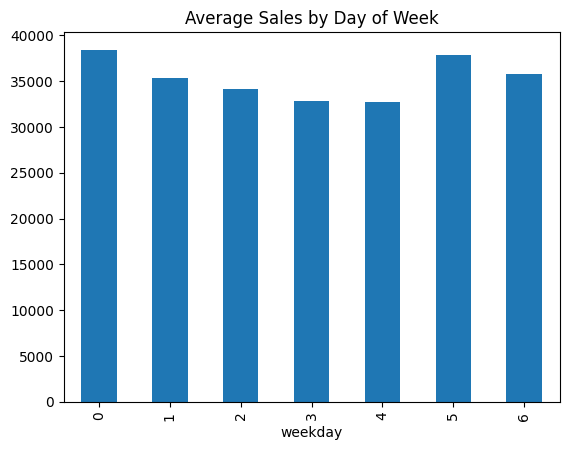

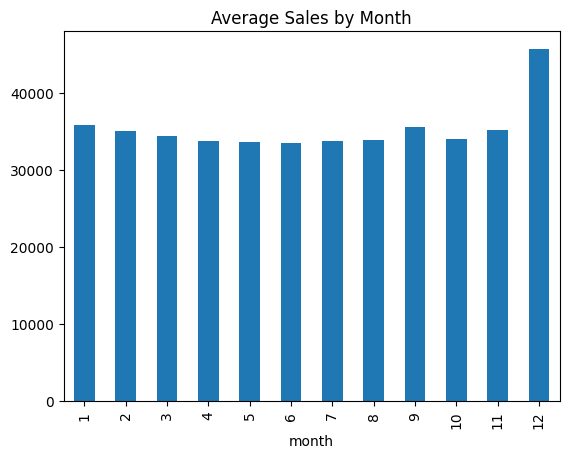

In [28]:
# Average sales by day of the week
data.groupby('weekday')['sales'].mean().plot(kind='bar', title="Average Sales by Day of Week")
plt.show()

# Average sales by month
data.groupby('month')['sales'].mean().plot(kind='bar', title="Average Sales by Month")
plt.show()

### Correlation between sales and weather

In [29]:
data.columns

Index(['sales', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'precip', 'precipcover', 'is_rain', 'windgust', 'windspeed', 'weekday',
       'week', 'day', 'month', 'year', 'day_of_year', 'is_holiday',
       'is_sunday', 'is_payday', 'is_holiday_1_lag', 'is_holiday_2_lag',
       'is_holiday_3_lag', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14',
       'sales_lag_28', 'sales_lag_364', 'sales_rolling_avg_7',
       'sales_rolling_avg_14', 'sales_rolling_avg_28',
       'sales_rolling_avg_364'],
      dtype='object')

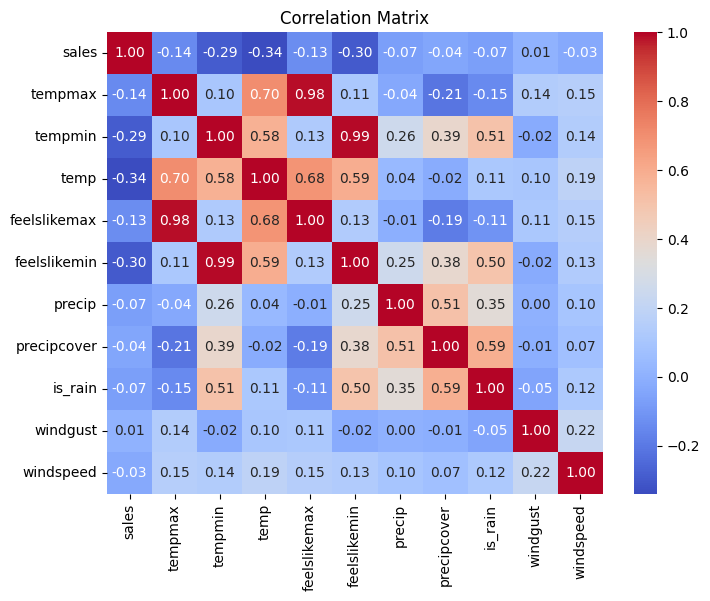

In [30]:
# Select numeric features
corr_df = data[['sales', 'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'precip', 'precipcover', 'is_rain', 'windgust', 'windspeed']].corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Scatter Plots (Sales vs. Weather Features)

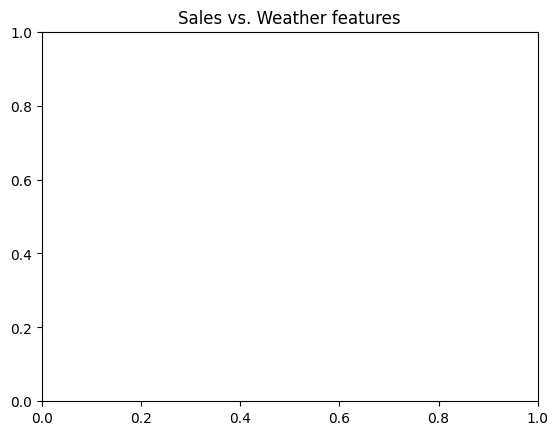

<Figure size 500x500 with 0 Axes>

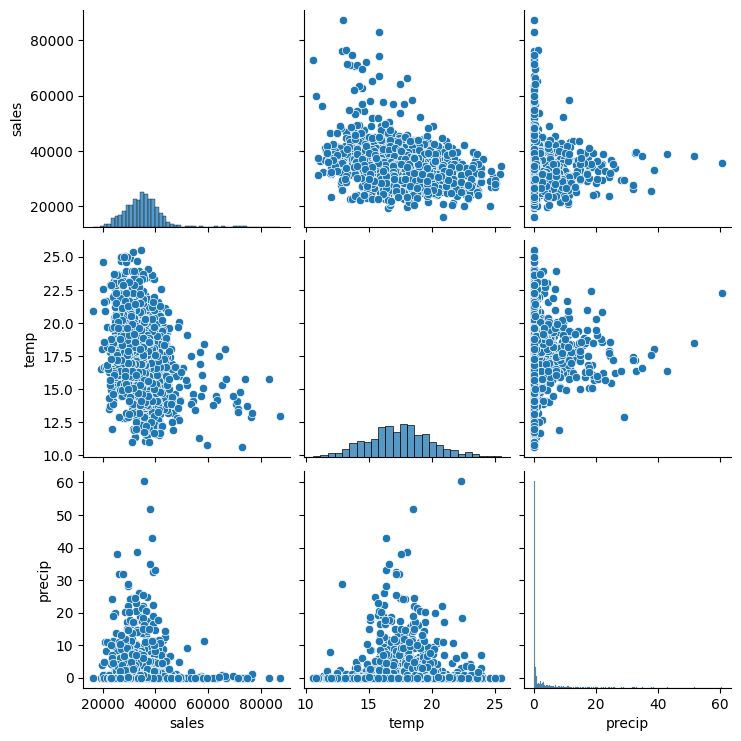

In [31]:
# Plot sales vs weather features scatter plots
plt.title('Sales vs. Weather features')
plt.figure(figsize=(5, 5))
sns.pairplot(data[['sales', 'temp', 'precip']])
plt.show()

### Rolling Sales Trends

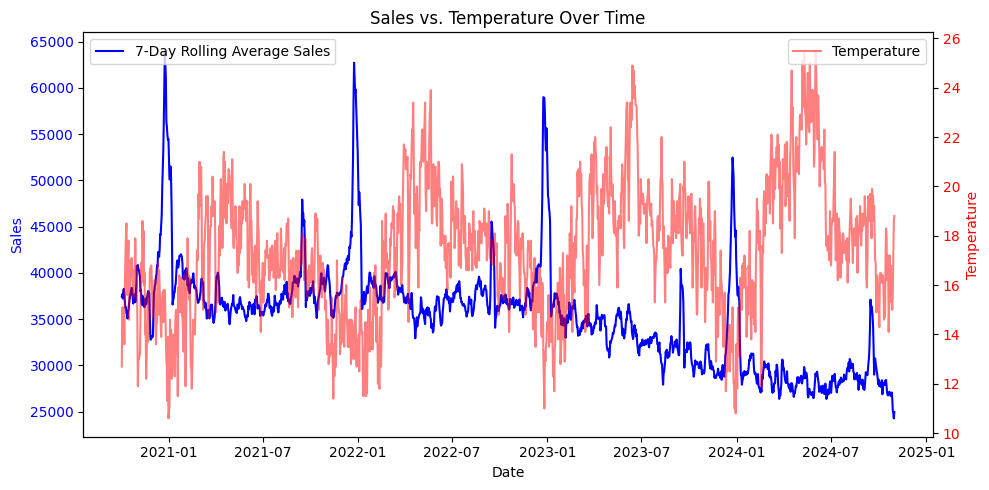

In [32]:
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot sales on the primary y-axis (ax1)
ax1.plot(data.index, data['sales_rolling_avg_7'], label='7-Day Rolling Average Sales', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis (ax2)
ax2 = ax1.twinx()  # Share the same x-axis

# Plot temperature on the secondary y-axis (ax2)
ax2.plot(data.index, data['temp'], label='Temperature', color='red', alpha=0.5)
ax2.set_ylabel('Temperature', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legends for both axes
ax1.legend(loc='upper left')  # Sales legend
ax2.legend(loc='upper right')  # Temperature legend

plt.title('Sales vs. Temperature Over Time')
fig.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()


## API

### Set up API for weather data

In [33]:
# Set up variables to create url for API
API_KEY = 'CK35K2LC7AG646872VCECEA7H'
CITY = 'Mexico%20City%2CMexico'
BASE_URL = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/'

### Get 15 days of weather forecast

In [34]:
def get_weather_forecast(df):
  '''
  Get 15 days of weather forecast from API and add it to dataframe
  '''
  # Create url with 'BASE_URL', 'CITY' and 'API_KEY' variable to connect with API
  url = f"{BASE_URL}{CITY}?unitGroup=metric&include=days&key={API_KEY}&contentType=json"

  # Save request in 'response' variable and format it to .json
  response = requests.get(url)
  API_data = response.json()

  # Convert the ['days'] part of the API response to a dataframe
  df = pd.json_normalize(API_data['days'])

  # Format 'preciptype' column
  df['preciptype'] = df['preciptype'].str[0]
  return df

In [35]:
# Create new dataframe
fifteen_days_forecast = pd.DataFrame()

# Use function 'get_weather_forecast' to get 15 days of weather forecast from API
fifteen_days_forecast = get_weather_forecast(fifteen_days_forecast)

In [36]:
# Clean fifteen_days_forecast weather data with function
fifteen_days_forecast = clean_weather_data(fifteen_days_forecast)

In [37]:
# Check the new dataframe with the weather data from the API
fifteen_days_forecast.head()

,date,tempmax,tempmin,temp,feelslikemax,feelslikemin,precip,precipcover,is_rain,windgust,windspeed
0,2025-02-23,23.8,10.0,18.6,23.8,10.0,0.0,0.00,no_rain,16.6,14.8
1,2025-02-24,23.1,15.2,18.7,23.1,15.2,0.1,4.17,rain,22.0,21.6
2,2025-02-25,23.9,14.2,18.9,23.9,14.2,0.0,0.00,no_rain,17.3,14.8
3,2025-02-26,25.5,14.9,20.1,25.5,14.9,0.0,0.00,no_rain,11.2,10.1
4,2025-02-27,24.8,13.6,19.0,24.8,13.6,0.0,0.00,no_rain,27.4,28.8


### Get next 15 days of weather data

In [38]:
def get_next_fifteen_days_weather(df):
  '''
  Get the next 15 days of weather data from API
  '''
  # Find the last date of the dataframe
  last_date = df.index.max().strftime('%Y-%m-%d')
  # Add 15 days to last date
  next_date = (pd.to_datetime(last_date) + pd.DateOffset(days=15)).strftime('%Y-%m-%d')

  # Print dates
  print(f'Last date: {last_date}')
  print(f'Next date: {next_date}')

  # Generate url and call API
  url = f"{BASE_URL}{CITY}/{last_date}/{next_date}?unitGroup=metric&include=days&key={API_KEY}&contentType=json"
  response = requests.get(url)
  API_data = response.json()

  # Format new weather data
  new_weather = pd.json_normalize(API_data['days'])
  new_weather['preciptype'] = new_weather['preciptype'].str[0]
  new_weather = clean_weather_data(new_weather)
  new_weather['date'] = pd.to_datetime(new_weather['date'])
  new_weather = new_weather.set_index('date')

  # Create new column 'is_future' in each dataframe to know if it's future data
  df['is_future'] = False
  new_weather['is_future'] = True

  # Merge new weather data with existing data
  original_columns = df.columns
  df = df.combine_first(new_weather)
  df = df.reindex(columns=original_columns)

  # Pring last 15 rows of dataframe
  print('Updated rows:')
  print(df.tail(15))
  return df

### Get weather data for new sales dates

In [39]:
def get_new_weather(df):
  '''
  Get weather data for new sales dates from API
  '''
  # Find the first and last date with weather missing values
  missing_tempmax = df[df['tempmax'].isna()]
  first_date = missing_tempmax.index.min().strftime('%Y-%m-%d')
  last_date = missing_tempmax.index.max().strftime('%Y-%m-%d')

  # Generate url and call API
  url = f"{BASE_URL}{CITY}/{first_date}/{last_date}?unitGroup=metric&include=days&key={API_KEY}&contentType=json"
  response = requests.get(url)
  API_data = response.json()

  # Format new weather data
  new_weather = pd.json_normalize(API_data['days'])
  new_weather['preciptype'] = new_weather['preciptype'].str[0]
  new_weather = clean_weather_data(new_weather)
  new_weather['date'] = pd.to_datetime(new_weather['date'])
  new_weather = new_weather.set_index('date')
  new_weather = new_weather.loc[missing_tempmax.index]

  # Merge new weather data with existing data
  original_columns = df.columns
  df = df.combine_first(new_weather)
  df = df.reindex(columns=original_columns)
  #df = add_features(df)

  print('Updated rows:')
  print(df.loc[missing_tempmax.index])
  return df

## Add new sales data

In [40]:
def add_sales_data(df):
    '''
    Ask for date and sales amount and add it to dataframe
    '''
    # Loop in case user inputs wrong date format
    while True:
        try:
            # Ask for date and convert to datetime
            date = input("Enter the date (YYYY-MM-DD): ")
            date = pd.to_datetime(date, format="%Y-%m-%d")  # Ensures correct format

            # Ask for sales amount and convert to float
            sales = float(input("Enter the sales amount: "))

            # Break loop if everything is valid
            break
        # Keep looping in case of error and show message
        except ValueError:
            print("Invalid input. Please enter the date in 'YYYY-MM-DD' format and a numeric sales value.")

    # Check if data is already in 'data' dataframe and update it if it is
    if date in df.index:
        print(f"\nDate {date.date()} already exists! Updating sales value from {df.loc[date, 'sales']} to {sales}.")
        # Modify existing value
        df.loc[date, 'sales'] = sales
    else:
        print(f"\nAdding new row for date {date.date()} with sales value {sales}")
        # Create new row as a DataFrame
        new_row = pd.DataFrame({"sales": [sales]}, index = [date])

        # Append the new row
        df = pd.concat([df, new_row])
        df = df.sort_index()
        df.index.name = 'date'

    # Pring last rows of updated dataframe
    print("\nUpdated data:")
    print(df.loc[[date], ['sales']])

    return df

In [41]:
# Call 'add_sales_data' 3 times to add 3 new days of sales
# date: 2024-11-01
# sales: 28024.8
data = add_sales_data(data)

Enter the date (YYYY-MM-DD): 2024-11-01
Enter the sales amount: 28024.8

Adding new row for date 2024-11-01 with sales value 28024.8

Updated data:
              sales
date               
2024-11-01  28024.8


In [42]:
# date: 2024-11-02
# sales: 31300.52
data = add_sales_data(data)

Enter the date (YYYY-MM-DD): 2024-11-02
Enter the sales amount: 31300.52

Adding new row for date 2024-11-02 with sales value 31300.52

Updated data:
               sales
date                
2024-11-02  31300.52


In [43]:
# date: 2024-11-03
# sales: 30184.02
data = add_sales_data(data)

Enter the date (YYYY-MM-DD): 2024-11-03
Enter the sales amount: 30184.02

Adding new row for date 2024-11-03 with sales value 30184.02

Updated data:
               sales
date                
2024-11-03  30184.02


### Update new sales with weather data

In [44]:
# Get missing weather data from 'data' dataframe
data = get_new_weather(data)

Updated rows:
               sales  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
date                                                                       
2024-11-01  28024.80     23.9     13.3  18.3          23.9          13.3   
2024-11-02  31300.52     24.3     10.9  17.5          24.3          10.9   
2024-11-03  30184.02     24.0     12.0  17.8          24.0          12.0   

            precip  precipcover  is_rain  windgust  windspeed  weekday  week  \
date                                                                           
2024-11-01     0.0         0.00  no_rain      28.4       18.3      NaN  <NA>   
2024-11-02     0.6         4.17     rain      18.7       14.8      NaN  <NA>   
2024-11-03     1.9        12.50     rain      18.0       25.8      NaN  <NA>   

            day  month  year  day_of_year  is_holiday  is_sunday  is_payday  \
date                                                                          
2024-11-01  NaN    NaN   NaN          NaN     

In [45]:
# Add all features to new data
data = add_features(data)

<ipython-input-17-a6233e6d2d21>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_rain'] = df['is_rain'].replace({'rain': 1, 'no_rain': 0})


## Data Model

### Time Series Cross Validation

In [46]:
# Create Time Series Split to split data for training
tss = TimeSeriesSplit(n_splits=48, test_size=15, gap = 7)

In [47]:
# Check 'tss' variable to verify split
tss

TimeSeriesSplit(gap=7, max_train_size=None, n_splits=48, test_size=15)

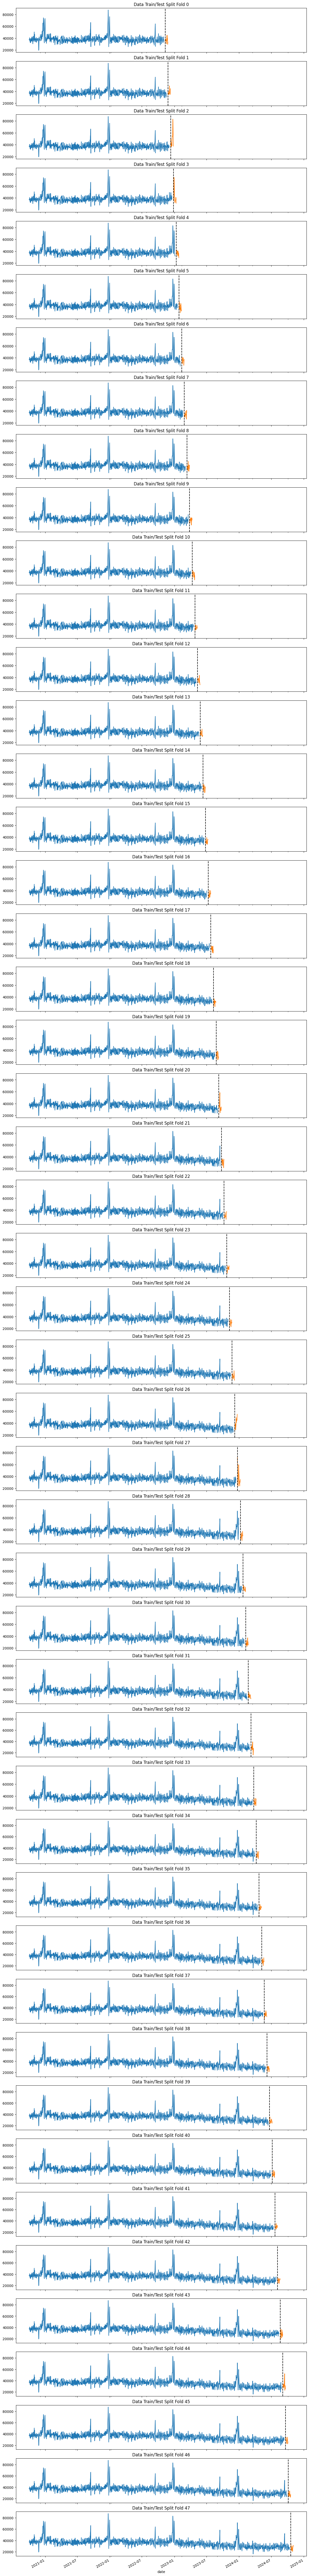

In [48]:
# Plot train/test splits
fig, axs = plt.subplots(48, 1, figsize=(15, 150), sharex = True)

fold = 0
for train_idx, val_idx in tss.split(data):
  train = data.iloc[train_idx]
  test = data.iloc[val_idx]
  train['sales'].plot(ax=axs[fold],
                    label='Training Set',
                    title=f'Data Train/Test Split Fold {fold}')
  test['sales'].plot(ax=axs[fold], label='Test Set')
  axs[fold].axvline(test.index.min(), color='black', ls='--')
  fold += 1

### Train using cross validation

In [49]:
# Split the data for Time Series data
tss = TimeSeriesSplit(n_splits=48, test_size=15, gap = 7)
data = data.sort_index()

fold = 0
preds = []
rmse_scores = []
mae_scores = []
mape_scores = []
r2_scores = []

for train_idx, val_idx in tss.split(data):
  train = data.iloc[train_idx]
  test = data.iloc[val_idx]

  train = add_features(train)
  test = add_features(test)

  # Define features and target data
  FEATURES = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'precip',
       'precipcover', 'is_rain', 'windgust', 'windspeed', 'weekday', 'week',
       'day', 'month', 'year', 'day_of_year', 'is_holiday', 'is_sunday',
       'is_payday', 'is_holiday_1_lag', 'is_holiday_2_lag', 'is_holiday_3_lag',
       'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28',
       'sales_lag_364', 'sales_rolling_avg_7', 'sales_rolling_avg_14',
       'sales_rolling_avg_28', 'sales_rolling_avg_364']
  TARGET = 'sales'

  # Create x and y train and test dataset with features and target
  x_train = train[FEATURES]
  y_train = train[TARGET]

  x_test = test[FEATURES]
  y_test = test[TARGET]


  # Tune regressor model
  reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                         n_estimators=500,
                         early_stopping_rounds=50,
                         objective='reg:linear',
                         max_depth=3,
                         learning_rate=0.01)

  # Fit model on train and test sets
  reg.fit(x_train, y_train,
          eval_set=[(x_train, y_train), (x_test, y_test)],
          verbose=100)

  # Predict on test
  y_pred = reg.predict(x_test)
  preds.append(y_pred)

  # Calculate metrics
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mae = mean_absolute_error(y_test, y_pred)
  mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
  r2 = r2_score(y_test, y_pred)

  # Store metrics for this fold
  rmse_scores.append(rmse)
  mae_scores.append(mae)
  mape_scores.append(mape)
  r2_scores.append(r2)

[0]	validation_0-rmse:38455.34451	validation_1-rmse:36590.04974


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:20] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:14663.43908	validation_1-rmse:14023.89242
[200]	validation_0-rmse:6239.55925	validation_1-rmse:6381.03964
[300]	validation_0-rmse:3641.27754	validation_1-rmse:4205.80566
[400]	validation_0-rmse:2967.85697	validation_1-rmse:3662.80062
[499]	validation_0-rmse:2744.29652	validation_1-rmse:3470.50500
[0]	validation_0-rmse:38402.03108	validation_1-rmse:38539.12276


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:23] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:14637.64948	validation_1-rmse:14816.38225
[200]	validation_0-rmse:6225.70562	validation_1-rmse:6670.26380
[300]	validation_0-rmse:3627.75272	validation_1-rmse:4096.15036
[400]	validation_0-rmse:2959.12061	validation_1-rmse:3451.33105
[499]	validation_0-rmse:2732.75824	validation_1-rmse:3354.12945
[0]	validation_0-rmse:38384.45500	validation_1-rmse:50783.73728
[100]	validation_0-rmse:14628.35384	validation_1-rmse:22591.06880


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:24] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6220.60042	validation_1-rmse:11888.60033
[300]	validation_0-rmse:3643.53603	validation_1-rmse:8758.26088
[400]	validation_0-rmse:2988.00029	validation_1-rmse:7717.66274
[499]	validation_0-rmse:2763.59441	validation_1-rmse:7385.54628
[0]	validation_0-rmse:38420.29721	validation_1-rmse:43026.77715
[100]	validation_0-rmse:14646.52822	validation_1-rmse:19929.58241


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6235.12603	validation_1-rmse:12240.41572
[300]	validation_0-rmse:3668.99893	validation_1-rmse:10280.93415
[400]	validation_0-rmse:3008.65517	validation_1-rmse:9657.03069
[499]	validation_0-rmse:2790.72297	validation_1-rmse:9381.87676
[0]	validation_0-rmse:38762.27661	validation_1-rmse:36120.85031
[100]	validation_0-rmse:14812.36283	validation_1-rmse:13284.52867


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:25] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6346.93293	validation_1-rmse:5535.44274
[300]	validation_0-rmse:3736.97295	validation_1-rmse:3434.43966
[400]	validation_0-rmse:3045.80648	validation_1-rmse:3041.38930
[499]	validation_0-rmse:2840.76064	validation_1-rmse:2954.78075
[0]	validation_0-rmse:38725.05093	validation_1-rmse:34538.16075
[100]	validation_0-rmse:14798.46420	validation_1-rmse:12806.87902


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:26] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6342.38080	validation_1-rmse:5962.44324
[300]	validation_0-rmse:3734.21693	validation_1-rmse:4532.79790
[400]	validation_0-rmse:3043.13486	validation_1-rmse:4401.91881
[440]	validation_0-rmse:2932.39870	validation_1-rmse:4398.78350
[0]	validation_0-rmse:38653.45615	validation_1-rmse:35989.95481
[100]	validation_0-rmse:14773.47520	validation_1-rmse:13403.00794


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:27] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6348.72678	validation_1-rmse:5523.24269
[300]	validation_0-rmse:3756.15677	validation_1-rmse:3487.51373
[400]	validation_0-rmse:3077.12716	validation_1-rmse:3250.04596
[499]	validation_0-rmse:2876.85223	validation_1-rmse:3245.07782
[0]	validation_0-rmse:38608.62838	validation_1-rmse:34070.25795
[100]	validation_0-rmse:14754.79035	validation_1-rmse:12107.11453


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:28] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6339.30243	validation_1-rmse:4772.85336
[300]	validation_0-rmse:3755.57307	validation_1-rmse:3206.56469
[400]	validation_0-rmse:3074.36018	validation_1-rmse:3090.04937
[425]	validation_0-rmse:3003.58817	validation_1-rmse:3100.94969
[0]	validation_0-rmse:38539.32383	validation_1-rmse:34446.64788
[100]	validation_0-rmse:14723.47790	validation_1-rmse:12444.63602


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:29] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6327.71188	validation_1-rmse:5217.00006
[300]	validation_0-rmse:3748.87379	validation_1-rmse:3710.86176
[400]	validation_0-rmse:3080.77962	validation_1-rmse:3566.49574
[499]	validation_0-rmse:2867.02785	validation_1-rmse:3551.21852
[0]	validation_0-rmse:38485.22051	validation_1-rmse:34731.48854
[100]	validation_0-rmse:14706.77292	validation_1-rmse:12811.34651


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6328.35273	validation_1-rmse:5217.20976
[300]	validation_0-rmse:3756.30603	validation_1-rmse:3266.22267
[400]	validation_0-rmse:3088.04395	validation_1-rmse:2857.96677
[499]	validation_0-rmse:2877.89065	validation_1-rmse:2837.28705
[0]	validation_0-rmse:38414.41448	validation_1-rmse:33589.28667
[100]	validation_0-rmse:14676.24003	validation_1-rmse:12036.75407


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:30] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6302.73379	validation_1-rmse:5241.83082
[300]	validation_0-rmse:3732.22799	validation_1-rmse:4151.24701
[395]	validation_0-rmse:3080.69996	validation_1-rmse:4108.60093
[0]	validation_0-rmse:38362.79590	validation_1-rmse:32948.23453
[100]	validation_0-rmse:14651.76754	validation_1-rmse:11279.50869


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:31] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6281.94878	validation_1-rmse:3817.01883
[300]	validation_0-rmse:3712.25031	validation_1-rmse:2072.52400
[389]	validation_0-rmse:3085.47371	validation_1-rmse:2008.09543
[0]	validation_0-rmse:38267.98175	validation_1-rmse:34357.49306
[100]	validation_0-rmse:14620.88457	validation_1-rmse:12428.83074


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:32] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6284.09044	validation_1-rmse:5123.70075
[300]	validation_0-rmse:3730.84317	validation_1-rmse:3331.37730
[400]	validation_0-rmse:3075.76484	validation_1-rmse:3085.30056
[499]	validation_0-rmse:2881.33447	validation_1-rmse:3057.56040
[0]	validation_0-rmse:38214.88333	validation_1-rmse:35012.23393
[100]	validation_0-rmse:14595.78683	validation_1-rmse:13193.15786


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:33] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6265.33589	validation_1-rmse:5463.94245
[300]	validation_0-rmse:3719.60182	validation_1-rmse:3336.60629
[400]	validation_0-rmse:3066.52533	validation_1-rmse:2958.53334
[488]	validation_0-rmse:2889.10633	validation_1-rmse:2945.81004
[0]	validation_0-rmse:38155.30397	validation_1-rmse:32905.67795


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:35] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:14569.78102	validation_1-rmse:11714.29210
[200]	validation_0-rmse:6244.79080	validation_1-rmse:4721.60497
[300]	validation_0-rmse:3704.70910	validation_1-rmse:3491.96399
[400]	validation_0-rmse:3053.05915	validation_1-rmse:3453.35981
[499]	validation_0-rmse:2869.70724	validation_1-rmse:3403.12424
[0]	validation_0-rmse:38105.03738	validation_1-rmse:32571.78008
[100]	validation_0-rmse:14547.84096	validation_1-rmse:11495.12821


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6246.58917	validation_1-rmse:4149.58106
[300]	validation_0-rmse:3717.65842	validation_1-rmse:2706.60618
[400]	validation_0-rmse:3077.27349	validation_1-rmse:2672.50324
[415]	validation_0-rmse:3037.05105	validation_1-rmse:2689.02960
[0]	validation_0-rmse:38023.34702	validation_1-rmse:32713.74238
[100]	validation_0-rmse:14520.71394	validation_1-rmse:11532.10273


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:39] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6233.95144	validation_1-rmse:4231.94753
[300]	validation_0-rmse:3716.64323	validation_1-rmse:2750.56047
[393]	validation_0-rmse:3108.23600	validation_1-rmse:2734.44306
[0]	validation_0-rmse:37946.10095	validation_1-rmse:31139.81594
[100]	validation_0-rmse:14489.06620	validation_1-rmse:10241.47891


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:40] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6227.88013	validation_1-rmse:3876.67591
[300]	validation_0-rmse:3720.75108	validation_1-rmse:3486.94614
[308]	validation_0-rmse:3633.12776	validation_1-rmse:3492.04083
[0]	validation_0-rmse:37870.54242	validation_1-rmse:30658.10716
[100]	validation_0-rmse:14455.50423	validation_1-rmse:9791.41027


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6204.58271	validation_1-rmse:3655.86228
[291]	validation_0-rmse:3813.87223	validation_1-rmse:3552.46445
[0]	validation_0-rmse:37773.91530	validation_1-rmse:31778.29599
[100]	validation_0-rmse:14424.86450	validation_1-rmse:11044.36788


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:41] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6204.54570	validation_1-rmse:4565.15256
[300]	validation_0-rmse:3718.09142	validation_1-rmse:3685.38626
[369]	validation_0-rmse:3196.53855	validation_1-rmse:3712.72648
[0]	validation_0-rmse:37687.55715	validation_1-rmse:35632.13034
[100]	validation_0-rmse:14401.68032	validation_1-rmse:14589.99552


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:42] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6206.05206	validation_1-rmse:8399.00079
[300]	validation_0-rmse:3730.19074	validation_1-rmse:7323.43991
[400]	validation_0-rmse:3097.62423	validation_1-rmse:7197.24150
[499]	validation_0-rmse:2902.34133	validation_1-rmse:7150.67573
[0]	validation_0-rmse:37667.32425	validation_1-rmse:31196.01954
[100]	validation_0-rmse:14406.70377	validation_1-rmse:10601.12343


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:43] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6227.81020	validation_1-rmse:4417.91796
[300]	validation_0-rmse:3759.47968	validation_1-rmse:3966.71178
[330]	validation_0-rmse:3477.30267	validation_1-rmse:4078.21553
[0]	validation_0-rmse:37590.64084	validation_1-rmse:30201.98245
[100]	validation_0-rmse:14375.49327	validation_1-rmse:9398.18953


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6225.58747	validation_1-rmse:3205.21647
[281]	validation_0-rmse:4014.84767	validation_1-rmse:3149.99549
[0]	validation_0-rmse:37499.12074	validation_1-rmse:30600.06438
[100]	validation_0-rmse:14340.59153	validation_1-rmse:9962.61010


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:44] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6216.66090	validation_1-rmse:4032.65148
[300]	validation_0-rmse:3758.89039	validation_1-rmse:3654.27784
[326]	validation_0-rmse:3509.00744	validation_1-rmse:3684.39401
[0]	validation_0-rmse:37406.64858	validation_1-rmse:29013.61678
[100]	validation_0-rmse:14306.85040	validation_1-rmse:8299.56442


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6207.12574	validation_1-rmse:3134.78127
[249]	validation_0-rmse:4614.09445	validation_1-rmse:3408.13142
[0]	validation_0-rmse:37325.73621	validation_1-rmse:28584.13882
[100]	validation_0-rmse:14268.20192	validation_1-rmse:8005.81357


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:45] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6184.17518	validation_1-rmse:3877.62763
[235]	validation_0-rmse:4950.49180	validation_1-rmse:4300.91294
[0]	validation_0-rmse:37223.16818	validation_1-rmse:40589.10009
[100]	validation_0-rmse:14231.66166	validation_1-rmse:13953.66387


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:46] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6164.40715	validation_1-rmse:6647.69315
[300]	validation_0-rmse:3733.15859	validation_1-rmse:5026.98743
[400]	validation_0-rmse:3128.70260	validation_1-rmse:4814.91647
[499]	validation_0-rmse:2940.99562	validation_1-rmse:4725.46996
[0]	validation_0-rmse:37161.49521	validation_1-rmse:40397.03208


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:14204.35634	validation_1-rmse:17561.80163
[200]	validation_0-rmse:6165.22451	validation_1-rmse:12662.58620
[300]	validation_0-rmse:3769.58362	validation_1-rmse:12340.21915
[312]	validation_0-rmse:3649.46582	validation_1-rmse:12350.19900
[0]	validation_0-rmse:37302.69921	validation_1-rmse:28988.49596
[100]	validation_0-rmse:14275.00956	validation_1-rmse:8436.21656


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:49] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6222.69774	validation_1-rmse:3989.21562
[246]	validation_0-rmse:4722.34679	validation_1-rmse:4233.15852
[0]	validation_0-rmse:37215.87316	validation_1-rmse:29728.75198
[100]	validation_0-rmse:14248.42969	validation_1-rmse:9210.15484


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:50] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6228.45646	validation_1-rmse:2847.34981
[299]	validation_0-rmse:3852.54759	validation_1-rmse:2484.17670
[0]	validation_0-rmse:37135.69049	validation_1-rmse:28203.74326


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:14221.23623	validation_1-rmse:8500.01910
[200]	validation_0-rmse:6216.03126	validation_1-rmse:4003.76542
[263]	validation_0-rmse:4356.22840	validation_1-rmse:4095.09982
[0]	validation_0-rmse:37034.98101	validation_1-rmse:28868.32717
[100]	validation_0-rmse:14184.14755	validation_1-rmse:8612.42417


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:51] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6207.56015	validation_1-rmse:2670.52976
[283]	validation_0-rmse:4045.41368	validation_1-rmse:2664.24760
[0]	validation_0-rmse:36954.03080	validation_1-rmse:27861.56048
[100]	validation_0-rmse:14154.15403	validation_1-rmse:8566.89896


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6199.80199	validation_1-rmse:4823.73528
[278]	validation_0-rmse:4101.89532	validation_1-rmse:4958.50849
[0]	validation_0-rmse:36864.11200	validation_1-rmse:29571.16022
[100]	validation_0-rmse:14121.87426	validation_1-rmse:9458.72777


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:52] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6191.91825	validation_1-rmse:3689.99119
[289]	validation_0-rmse:3945.91605	validation_1-rmse:3448.81083
[0]	validation_0-rmse:36776.29555	validation_1-rmse:27436.71043
[100]	validation_0-rmse:14093.13760	validation_1-rmse:7859.79279


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:53] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6187.57849	validation_1-rmse:3482.68851
[254]	validation_0-rmse:4545.30897	validation_1-rmse:3686.49570
[0]	validation_0-rmse:36691.07122	validation_1-rmse:28194.12077
[100]	validation_0-rmse:14057.86900	validation_1-rmse:8140.34327


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6168.93674	validation_1-rmse:2679.93387
[266]	validation_0-rmse:4297.60227	validation_1-rmse:2835.28353
[0]	validation_0-rmse:36599.42681	validation_1-rmse:27924.72376
[100]	validation_0-rmse:14019.78178	validation_1-rmse:8006.96987


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:54] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6156.39550	validation_1-rmse:2953.58712
[257]	validation_0-rmse:4459.09376	validation_1-rmse:3250.11353
[0]	validation_0-rmse:36517.42920	validation_1-rmse:27497.21840
[100]	validation_0-rmse:13989.10473	validation_1-rmse:7842.00612


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6144.53773	validation_1-rmse:3567.20065
[238]	validation_0-rmse:4876.98167	validation_1-rmse:3796.53304
[0]	validation_0-rmse:36424.04901	validation_1-rmse:26985.27203
[100]	validation_0-rmse:13960.22073	validation_1-rmse:7574.42828


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:55] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6131.05248	validation_1-rmse:3125.69190
[237]	validation_0-rmse:4890.27210	validation_1-rmse:3412.61113
[0]	validation_0-rmse:36337.41049	validation_1-rmse:27869.46923
[100]	validation_0-rmse:13927.59540	validation_1-rmse:8216.62026


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6120.92565	validation_1-rmse:3068.43981
[256]	validation_0-rmse:4453.39980	validation_1-rmse:3371.63565
[0]	validation_0-rmse:36250.99961	validation_1-rmse:28013.81728
[100]	validation_0-rmse:13899.58064	validation_1-rmse:8284.83533


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:56] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6107.54432	validation_1-rmse:3095.17316
[256]	validation_0-rmse:4444.43181	validation_1-rmse:3352.76885
[0]	validation_0-rmse:36171.04204	validation_1-rmse:29245.69313
[100]	validation_0-rmse:13871.81172	validation_1-rmse:8854.44321


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6106.91735	validation_1-rmse:2685.16073
[281]	validation_0-rmse:4023.53635	validation_1-rmse:2737.65080
[0]	validation_0-rmse:36100.39927	validation_1-rmse:29388.37568
[100]	validation_0-rmse:13847.39826	validation_1-rmse:8993.94698


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:57] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6092.39280	validation_1-rmse:2669.60042
[287]	validation_0-rmse:3933.42744	validation_1-rmse:2544.95544
[0]	validation_0-rmse:36036.04951	validation_1-rmse:27899.60279
[100]	validation_0-rmse:13817.07975	validation_1-rmse:8515.49587


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:58] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6086.58347	validation_1-rmse:4733.59347
[247]	validation_0-rmse:4618.49953	validation_1-rmse:4920.05168
[0]	validation_0-rmse:35964.47249	validation_1-rmse:33203.23554
[100]	validation_0-rmse:13789.76349	validation_1-rmse:13392.21074


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:32:59] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6079.32940	validation_1-rmse:8176.97545
[300]	validation_0-rmse:3768.96899	validation_1-rmse:7235.00367
[381]	validation_0-rmse:3254.14238	validation_1-rmse:7227.11818
[0]	validation_0-rmse:35898.76437	validation_1-rmse:28651.82687


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:33:01] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:13772.45405	validation_1-rmse:8614.96121
[200]	validation_0-rmse:6079.26170	validation_1-rmse:3119.38037
[279]	validation_0-rmse:4037.84152	validation_1-rmse:3259.16434
[0]	validation_0-rmse:35868.88641	validation_1-rmse:27183.08737
[100]	validation_0-rmse:13769.26659	validation_1-rmse:7496.04543


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:33:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6095.37649	validation_1-rmse:3043.93317
[234]	validation_0-rmse:4961.17890	validation_1-rmse:3424.87726
[0]	validation_0-rmse:35795.52621	validation_1-rmse:26768.04583
[100]	validation_0-rmse:13744.57058	validation_1-rmse:7266.78120


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:33:02] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6093.14357	validation_1-rmse:3860.22273
[223]	validation_0-rmse:5278.70561	validation_1-rmse:4177.39906


### Model evaluation

In [50]:
# Print average scores across all folds
print(f'Average RMSE: {np.mean(rmse_scores):.4f}')
print(f'Average MAE: {np.mean(mae_scores):.4f}')
print(f'Average MAPE: {np.mean(mape_scores):.2f}%')
print(f'Average r2 Score: {np.mean(r2_scores):.4f}')
print('\n')

# Print all fold scores for reference
print(f'RMSE per fold: {rmse_scores}')
print(f'MAE per fold: {mae_scores}')
print(f'MAPE per fold: {mape_scores}')
print(f'r2 per fold: {r2_scores}')

Average RMSE: 3867.3484
Average MAE: 3004.7111
Average MAPE: 9.52%
Average r2 Score: 0.2629


RMSE per fold: [3470.504737228502, 3346.3861996504297, 7385.546552926954, 9381.877022266452, 2954.724083950294, 4394.599992889991, 3237.786002201088, 3079.0245308486633, 3550.555513473393, 2827.57399193516, 4097.146558955383, 1984.4157544618843, 3056.675334728504, 2934.9043381494866, 3401.968847676585, 2627.845185843728, 2710.210512158764, 3436.1765071089008, 3392.8607344481647, 3669.5723726695123, 7150.315525058862, 3917.357539086687, 3005.169450538193, 3627.666425705665, 3121.936401047222, 3814.442987382983, 4725.469545506056, 12311.855515329833, 3984.095800305787, 2364.125867766171, 3957.1174993660043, 2447.9565733292225, 4703.030352786649, 3339.344484882143, 3476.262805353756, 2617.4323772234347, 2939.163340086543, 3546.5019449667816, 3108.365301119329, 3062.190253286072, 3080.0646899004996, 2464.717540099056, 2354.0679451795977, 4726.338304602392, 7220.085824874113, 2995.1831190204884, 29

### Feature Importance

In [51]:
# Create table with feature importance
fi_table = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance']).sort_values('importance', ascending = False)

fi_table

,importance
sales_rolling_avg_7,0.205358
day_of_year,0.204465
is_holiday_1_lag,0.101159
sales_lag_7,0.098504
sales_lag_1,0.066442
sales_lag_14,0.059001
sales_lag_364,0.046053
sales_lag_28,0.040322
sales_rolling_avg_364,0.027033
windspeed,0.024517


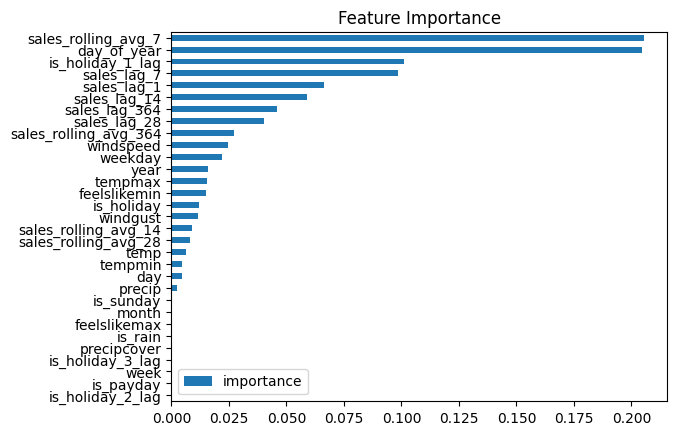

In [52]:
# Plot feature importance table
fi_table.sort_values('importance', ascending = True).plot(kind='barh', title='Feature Importance', )
plt.show()

### Retrain on all data

In [53]:
# Add all features to data dataframe and sort by index
data = add_features(data)
data = data.sort_index()

# Define features and target data
FEATURES = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'precip',
       'precipcover', 'is_rain', 'windgust', 'windspeed', 'weekday', 'week',
       'day', 'month', 'year', 'day_of_year', 'is_holiday', 'is_sunday',
       'is_payday', 'is_holiday_1_lag', 'is_holiday_2_lag', 'is_holiday_3_lag',
       'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28',
       'sales_lag_364', 'sales_rolling_avg_7', 'sales_rolling_avg_14',
       'sales_rolling_avg_28', 'sales_rolling_avg_364']
TARGET = 'sales'

# Create x and y variables with features and target
x_all = data[FEATURES]
y_all = data[TARGET]

# Tune model
reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)


In [54]:
# Fit model with all data
reg.fit(x_all, y_all,
        eval_set=[(x_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:35678.81804
[100]	validation_0-rmse:13700.52120


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:33:03] WARNING: /workspace/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:6072.46444
[300]	validation_0-rmse:3796.80207
[400]	validation_0-rmse:3221.52684
[499]	validation_0-rmse:3036.58263


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

### Predict the future

In [55]:
# Create a copy of 'data' dataframe
data_and_future = data.copy()

# Call API function to add the next 15 days of weather data
data_and_future = get_next_fifteen_days_weather(data_and_future)

# Add all features to 'data_and_future' dataframe
data_and_future = add_features(data_and_future)

Last date: 2024-11-03
Next date: 2024-11-18
Updated rows:
            sales  tempmax  tempmin  temp  feelslikemax  feelslikemin  precip  \
date                                                                            
2024-11-04    NaN     26.0     12.8  18.1          26.0          12.8     0.4   
2024-11-05    NaN     25.6     12.7  18.4          25.6          12.7     0.0   
2024-11-06    NaN     25.6     10.7  18.4          25.6          10.7     0.0   
2024-11-07    NaN     25.3     13.3  19.5          25.3          13.3     0.0   
2024-11-08    NaN     25.9     12.1  19.5          25.9          12.1     0.0   
2024-11-09    NaN     26.7     11.0  18.9          26.0          11.0     0.0   
2024-11-10    NaN     26.7      8.2  18.1          25.9           7.5     0.0   
2024-11-11    NaN     25.6     11.1  17.9          25.6          11.1     0.0   
2024-11-12    NaN     24.2      5.1  16.5          24.2           5.1     0.0   
2024-11-13    NaN     24.1      9.6  17.0          

<ipython-input-17-a6233e6d2d21>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['is_rain'] = df['is_rain'].replace({'rain': 1, 'no_rain': 0})


In [56]:
# Verify new weather data in dataframe
data_and_future.tail(20)

,sales,tempmax,tempmin,temp,feelslikemax,feelslikemin,precip,precipcover,is_rain,windgust,windspeed,weekday,week,day,month,year,day_of_year,is_holiday,is_sunday,is_payday,is_holiday_1_lag,is_holiday_2_lag,is_holiday_3_lag,sales_lag_1,sales_lag_7,sales_lag_14,sales_lag_28,sales_lag_364,sales_rolling_avg_7,sales_rolling_avg_14,sales_rolling_avg_28,sales_rolling_avg_364,is_future
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-10-30,20590.85,24.7,11.6,18.6,24.7,11.6,4.8,4.17,1.0,18.0,15.8,2,44,30,10,2024,304,0,0,0,0.0,0.0,0.0,23283.54,24394.54,23283.04,22391.51,36009.66,24262.228571,25651.847857,26678.913929,29519.990934,False
2024-10-31,26466.05,24.1,12.1,18.8,24.1,12.1,0.0,0.00,1.0,19.8,23.6,3,44,31,10,2024,305,0,0,1,0.0,0.0,0.0,20590.85,21735.82,24235.01,25966.48,31430.35,24937.975714,25811.207857,26696.755714,29506.352747,False
2024-11-01,28024.80,23.9,13.3,18.3,23.9,13.3,0.0,0.00,0.0,28.4,18.3,4,44,1,11,2024,306,0,0,0,0.0,0.0,0.0,26466.05,22640.04,22152.38,25648.07,33387.86,25707.227143,26230.666429,26781.638929,29491.619066,False
2024-11-02,31300.52,24.3,10.9,17.5,24.3,10.9,0.6,4.17,1.0,18.7,14.8,5,44,2,11,2024,307,0,0,0,0.0,0.0,0.0,28024.80,29031.57,26918.05,26728.51,30845.52,26031.362857,26543.700000,26944.925000,29492.869066,False
2024-11-03,30184.02,24.0,12.0,17.8,24.0,12.0,1.9,12.50,1.0,18.0,25.8,6,44,3,11,2024,308,0,1,0,0.0,0.0,0.0,31300.52,29765.52,34506.54,30953.03,29277.38,26091.148571,26234.948571,26917.460357,29495.359835,False
2024-11-04,NaN,26.0,12.8,18.1,26.0,12.8,0.4,12.50,1.0,22.3,20.1,0,45,4,11,2024,309,0,0,0,0.0,0.0,0.0,30184.02,22788.26,31521.06,32647.20,33109.52,26641.630000,25828.324615,26705.247778,29485.403471,True
2024-11-05,NaN,25.6,12.7,18.4,25.6,12.7,0.0,0.00,0.0,19.1,20.7,1,45,5,11,2024,310,0,0,0,0.0,0.0,0.0,NaN,23283.54,25562.69,23730.70,29374.64,27313.248000,25850.460833,26819.653462,29485.709448,True
2024-11-06,NaN,25.6,10.7,18.4,25.6,10.7,0.0,0.00,0.0,19.8,17.4,2,45,6,11,2024,311,0,0,0,0.0,0.0,0.0,NaN,20590.85,24394.54,28551.01,34359.85,28993.847500,25982.817273,26750.399200,29472.207673,True
2024-11-07,NaN,25.3,13.3,19.5,25.3,13.3,0.0,0.00,0.0,28.1,20.4,3,45,7,11,2024,312,0,0,0,0.0,0.0,0.0,NaN,26466.05,21735.82,28438.51,35643.86,29836.446667,26407.517000,26680.061250,29455.064194,True


In [57]:
# Create a copy of the dataframe with only the future values
future_w_features = data_and_future.query('is_future').copy()

In [58]:
# Verify data in copy with future data
future_w_features.head()

,sales,tempmax,tempmin,temp,feelslikemax,feelslikemin,precip,precipcover,is_rain,windgust,windspeed,weekday,week,day,month,year,day_of_year,is_holiday,is_sunday,is_payday,is_holiday_1_lag,is_holiday_2_lag,is_holiday_3_lag,sales_lag_1,sales_lag_7,sales_lag_14,sales_lag_28,sales_lag_364,sales_rolling_avg_7,sales_rolling_avg_14,sales_rolling_avg_28,sales_rolling_avg_364,is_future
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-04,NaN,26.0,12.8,18.1,26.0,12.8,0.4,12.5,1.0,22.3,20.1,0,45,4,11,2024,309,0,0,0,0.0,0.0,0.0,30184.02,22788.26,31521.06,32647.20,33109.52,26641.630000,25828.324615,26705.247778,29485.403471,True
2024-11-05,NaN,25.6,12.7,18.4,25.6,12.7,0.0,0.0,0.0,19.1,20.7,1,45,5,11,2024,310,0,0,0,0.0,0.0,0.0,NaN,23283.54,25562.69,23730.70,29374.64,27313.248000,25850.460833,26819.653462,29485.709448,True
2024-11-06,NaN,25.6,10.7,18.4,25.6,10.7,0.0,0.0,0.0,19.8,17.4,2,45,6,11,2024,311,0,0,0,0.0,0.0,0.0,NaN,20590.85,24394.54,28551.01,34359.85,28993.847500,25982.817273,26750.399200,29472.207673,True
2024-11-07,NaN,25.3,13.3,19.5,25.3,13.3,0.0,0.0,0.0,28.1,20.4,3,45,7,11,2024,312,0,0,0,0.0,0.0,0.0,NaN,26466.05,21735.82,28438.51,35643.86,29836.446667,26407.517000,26680.061250,29455.064194,True
2024-11-08,NaN,25.9,12.1,19.5,25.9,12.1,0.0,0.0,0.0,32.0,24.5,4,45,8,11,2024,313,0,0,0,0.0,0.0,0.0,NaN,28024.80,22640.04,24041.64,26975.34,30742.270000,26826.125556,26794.775217,29461.971504,True


In [59]:
# Predict next 15 days
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

In [60]:
# Print predictions
print(future_w_features['pred'])

date
2024-11-04    28356.009766
2024-11-05    26636.927734
2024-11-06    27339.314453
2024-11-07    27395.720703
2024-11-08    27267.279297
2024-11-09    30356.785156
2024-11-10    36692.484375
2024-11-11    40578.156250
2024-11-12    40199.390625
2024-11-13    39698.878906
2024-11-14    39420.601562
2024-11-15    39631.210938
2024-11-16    41246.542969
2024-11-17    40157.941406
2024-11-18    41333.847656
Name: pred, dtype: float32


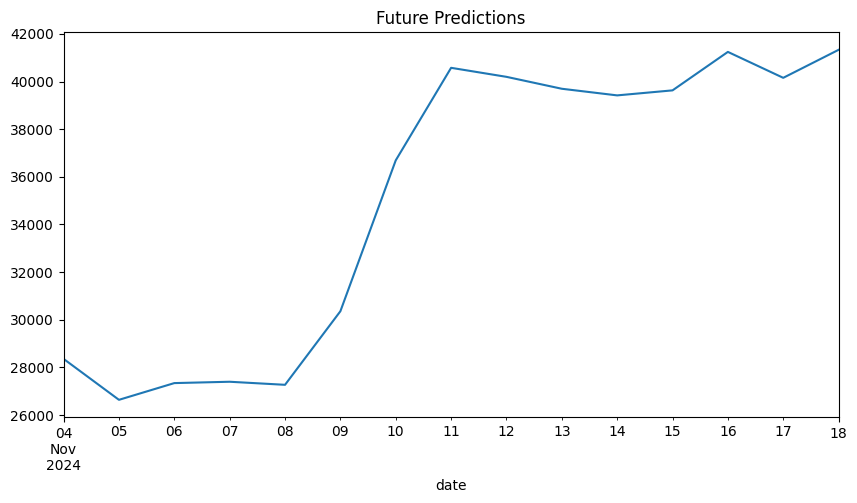

In [61]:
# Plot future predictions
future_w_features['pred'].plot(figsize=(10, 5),
                               title='Future Predictions')
plt.show()

### Evaluate predictions

In [63]:
# Add real sales values
future_w_features['real'] = [31127.55, 28311.90, 23796.38, 21259.44,  26418.08, 30759.03,
                             30097.86, 28251.45, 23522.51, 25473.52, 21004.13, 23923.16,
                             28913.57, 29919.84, 32418.72]

In [64]:
# Compare predictions vs real data
rmse_r = np.sqrt(mean_squared_error(future_w_features['real'], future_w_features['pred']))
mae_r = mean_absolute_error(future_w_features['real'], future_w_features['pred'])
mape_r = np.mean(np.abs((future_w_features['real'] - future_w_features['pred']) / future_w_features['real'])) * 100
r2_r = r2_score(future_w_features['real'], future_w_features['pred'])

# Print scores
print('Prediction vs real sales evaluation')
print(f'RMSE: {rmse_r:.4f}')
print(f'MAE: {mae_r:.4f}')
print(f'MAPE: {mape_r:.2f}%')
print(f'r2 Score: {r2_r:.4f}')


Prediction vs real sales evaluation
RMSE: 10519.1949
MAE: 8720.7644
MAPE: 34.21%
r2 Score: -7.7823


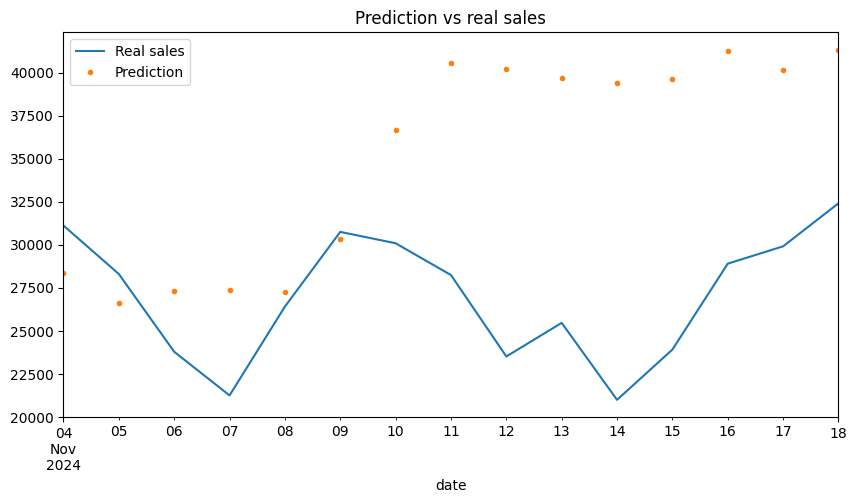

In [66]:
# Plot predictions vs real data
ax = future_w_features['real'].plot(figsize=(10, 5), title='Prediction vs real sales')
future_w_features['pred'].plot(style='.')
plt.legend(['Real sales','Prediction'])
plt.show()